# **Algorithmic Methods of Data Mining - Homework n°2**

#### <u>Danial Abri</u> - Matr: 1763128 
#### <u>Lorenzo Petroni</u> - Matr: 1607049

## <u>November 2020</u>

# $Preliminary$ $operations$

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

First we pull the data out for October and November seperately

In [133]:
november = pd.read_csv('2019-Nov.csv' , header = 'infer', nrows = 500000)
october = pd.read_csv('2019-Oct.csv', header = 'infer', nrows = 500000)

Here we concatenated two months in a single data frame

In [134]:
df = pd.concat([october,november]) #October + November dataset

Here we see the dataframes shape the number of objects and the number of the variabiles in our dataframe

In [135]:
df.shape

(1000000, 9)

We can see all the columns in our dataframe by using this command 

In [136]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

Here we see some of our objects and we can see what each column contains

In [137]:
df.info

<bound method DataFrame.info of                      event_time event_type  product_id          category_id  \
0       2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1       2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2       2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3       2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4       2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   
...                         ...        ...         ...                  ...   
499995  2019-11-01 09:18:16 UTC       view    21408811  2053013561579406073   
499996  2019-11-01 09:18:16 UTC       view    26300509  2053013563424899933   
499997  2019-11-01 09:18:17 UTC       view    10800074  2053013554994348409   
499998  2019-11-01 09:18:17 UTC       view     1005116  2053013555631882655   
499999  2019-11-01 09:18:17 UTC       view     1801623  2053013554415534427   

                   

By using this command we can see the type of every variabile, 
we should note that the event_time is an object and not a date_time object

In [138]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

By using this code we change the event_time type to a datetime object

In [139]:
df.event_time = pd.to_datetime(df.event_time)

As we can see from the cell below by running again the $df.types$ command, the event_time type changed from "object" to "datetime64"

In [140]:
df.dtypes

event_time       datetime64[ns, UTC]
event_type                    object
product_id                     int64
category_id                    int64
category_code                 object
brand                         object
price                        float64
user_id                        int64
user_session                  object
dtype: object

# $RQ1$

### $1.0$ Which is the rate of complete funnels?

Here we first create different lists for number of views, carts and purchases categorized by unique users and unique 
products in order to intersect all of them and get the users who has completed the funnel. Then we get the number of total
users and we devide the funnel.

In [141]:
user_view = df[df.event_type == 'view'].groupby(['user_id','product_id']).count()
user_cart = df[df.event_type == 'cart'].groupby(['user_id','product_id']).count()
user_purchase = df[df.event_type == 'purchase'].groupby(['user_id','product_id']).count()
funnels = user_view.index.intersection(user_cart.index.intersection(user_purchase.index))
rate = len(funnels) / df.user_session.nunique()
print("The rate of complete funnel is equal to ", rate)

The rate of complete funnel is equal to  0.02454062097677607


### $1.1$ What’s the operation users repeat more on average within a session?

In order to obtain the action repeated more on everage within a session, we first group the whole dataframe by $userSession$ and $eventType$. Then, for each group, we count all the events occurred in that session.<br> Finally, we group the dataframe just obtained again by $eventType$ and we compute the mean for each group.

In [142]:
session_event = df.groupby(["user_session", "event_type"]).event_type.count().sort_values(ascending = False)
session_event.groupby('event_type').mean()

event_type
cart        1.591732
purchase    1.166898
view        4.032946
Name: event_type, dtype: float64

### $1.2$ Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc)

For this exercise, we proceed in the same way as in exercise 1.1 but grouping by userID instead of by userSession.<br> Finally, a graph is generated showing the average number of times each operation is performed by a user.

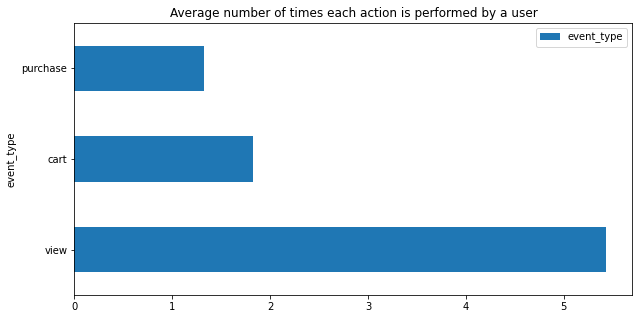

In [143]:
most_repeated_actions = df.groupby(["user_id","event_type"]).event_type.count().sort_values(ascending = False)
most_repeated_actions = most_repeated_actions.groupby("event_type").mean().sort_values(ascending = False)
plt.figure(figsize = (10,5))
plt.title("Average number of times each action is performed by a user")
most_repeated_actions.plot.barh()
plt.legend()
plt.show()

### $1.3$ How many times, on average, a user views a product before adding it to the cart?

What we did here is to find the first add-to-cart event after one or more view events for each product_ID/user_ID couple.

In [144]:
view_cart = df[df.event_type != 'purchase'].groupby(['user_id','product_id'])
avg_views = []
for value,frame in view_cart:
    view = 0
    append_to_list = False
    for i in range(frame.shape[0]):
        if frame.iloc[i]['event_type'] == 'view':
            view += 1
        if frame.iloc[i]['event_type'] =='cart' and view != 0:
            append_to_list = True
        if append_to_list:
            avg_views.append(view)
            break
print("The number of times a user views a product before adding it to the cart is ",np.mean(avg_views).round(3))

The number of times a user views a product before adding it to the cart is  1.819


### $1.4$ What’s the probability that products added once to the cart are effectively bought?

Here, again, for each product_ID/user_ID couple we count how many times, after an add-to-cart event we have also almost one purchase event. Then we compute the probability using the ratio between that number and the total number of add-to-cart events.

In [145]:
cart_purchase = df[df.event_type != 'view'].groupby(['user_id','product_id'])
success = 0
for value,frame in cart_purchase:
    cart = False
    successful = False
    for i in range(frame.shape[0]):
        if frame.iloc[i]['event_type'] == 'cart':
            cart = True
        if frame.iloc[i]['event_type'] =='purchase' and cart:
            successful = True
        if successful:
            success += 1
            break
cart_usr_pid = df[df.event_type == 'cart'].groupby(['product_id','user_id']).event_time.nunique().sum()
prob = success / cart_usr_pid
print("The required probability is equal to: ", prob.round(3) * 100, "%")

The required probability is equal to:  37.2 %


### $1.5$ What’s the average time an item stays in the cart before being removed?

Since we do not have the event 'remove from cart' we just can classify it as the difference 
between the number cart and purchase events

In [146]:
user_cart = df[df.event_type == 'cart'].groupby(['user_id','product_id']).count()
user_purchase = df[df.event_type == 'purchase'].groupby(['user_id','product_id']).count()
cart_purchase = user_cart.index.intersection(user_purchase.index)
num_rfc = len(user_cart) - len(cart_purchase)
print("The total number of remove-from-cart events is: ", num_rfc)

The total number of remove-from-cart events is:  4255


We can not provide a solution for the average time requested because we do not have the exact event time associated to the remove from cart event. We do not have such an event in our dataframe. The only thing we can do is to compute the number of times an add-to-cart event happens and purchase one does not.

### $1.6$ How much time passes on average between the first view time and a purchase/addition to cart?

First we group our dataset by $userID$ and $productID$ in order to provide an average-time computation measured on each user. <br>
In this case we collect in a list all the differences between an add-to-cart/purchase event and the corresponding first view event.
Then we compute the average value through all values contained in the list.

In [147]:
time_difference_list = []
for value, frame in df.groupby(['user_id','product_id']):
    view = False
    pu_ca = False
    time_view = 0
    time_pu_ca = 0
    for i in range(frame.shape[0]):
        if frame.iloc[i]['event_type'] == 'view':
            view = True
            time_view = frame.iloc[i]['event_time']
        if frame.iloc[i]['event_type'] != 'view' and view:
            pu_ca = True
            time_pu_ca = frame.iloc[i]['event_time']
        if pu_ca:
            time_difference_list.append((time_pu_ca-time_view))
            view = False
            pu_ca = False
average_time = sum(time_difference_list, datetime.timedelta(0)) / len(time_difference_list)
print("The average time between the first view of a product and the corresponding add-to-cart/purchase event is: ", average_time)

The average time between the first view of a product and the corresponding add-to-cart/purchase event is:  0 days 00:01:38.590065


# $RQ2$

### $2.0$ What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category. What are the 10 most sold products per category?

Since the $category code$ parameter contains information on the category and subcategory of each product, we have decided to split this field in correspondence with the "." symbol.<br>
In this way we are able to have access only to the main category.<br>
For example: $electronics.smarphone$ ---> $electronics$.<br>
Then we simply show the ten most trending categories overall, according with the sold products.

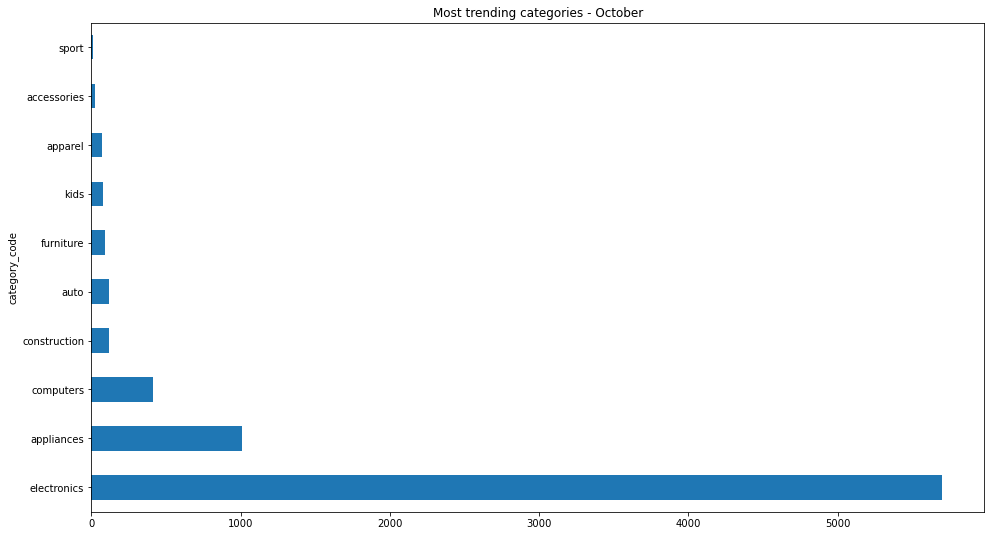

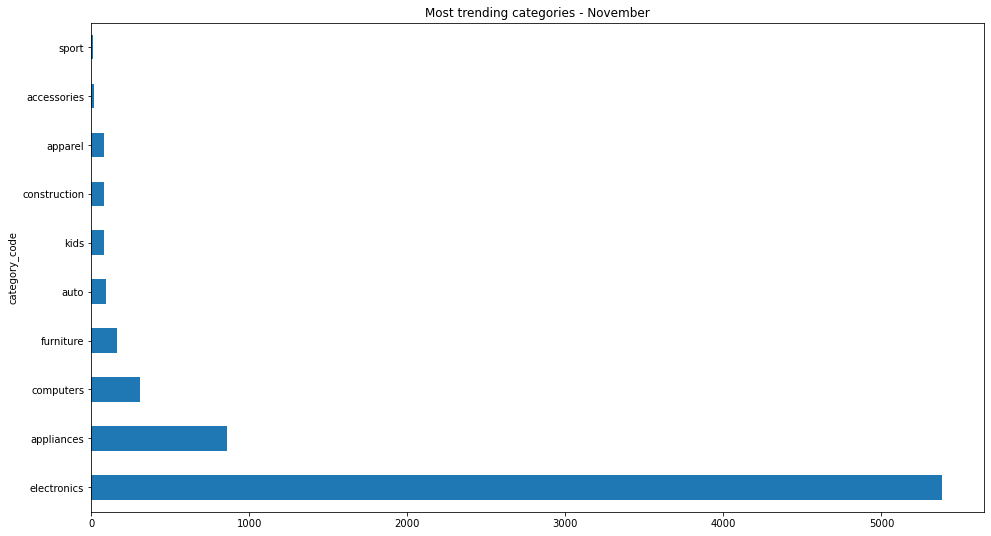

In [148]:
purchase_october = october[october.event_type == 'purchase']
purchase_october = purchase_october[purchase_october.category_code.notna()]
purchase_november = november[november.event_type == 'purchase']
purchase_november = purchase_november[purchase_november.category_code.notna()]
# For categories we only want the first word of the string
purchase_october['category_code'] = purchase_october['category_code'].str.split('.').str[0]
purchase_november['category_code'] = purchase_november['category_code'].str.split('.').str[0]
plt.figure()
plt.title("Most trending categories - October")
purchase_october.groupby('category_code').event_type.count().nlargest(10).plot.barh(figsize = (16,9))
plt.show()
plt.figure()
plt.title("Most trending categories - November")
purchase_november.groupby('category_code').event_type.count().nlargest(10).plot.barh(figsize = (16,9))
plt.show()

### $2.1$ Plot the most visited subcategories.

Here we worked in the same way as in the previous exercise but, in this case, we used the "subcategory" parameter.<br> For example: $electronics.smartphone$ ---> $smartphone$.

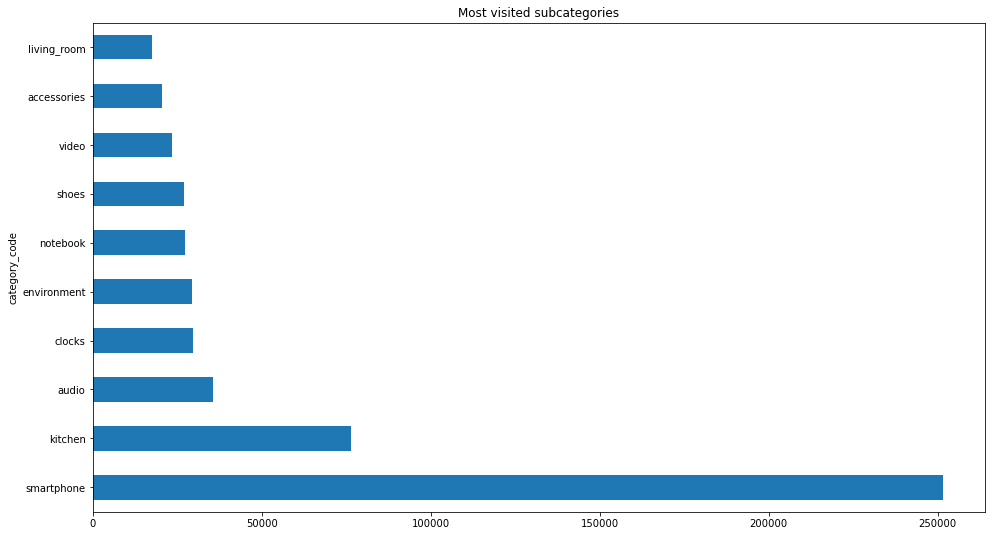

In [149]:
view_october = october[october.event_type == 'view']
view_october = view_october[view_october.category_code.notna()]
view_november = november[november.event_type == 'view']
view_november = view_november[view_november.category_code.notna()]
view_october['category_code'] = view_october['category_code'].str.split('.').str[1]
view_november['category_code'] = view_november['category_code'].str.split('.').str[1]
total_view_sub = pd.concat([view_october,view_november])
plt.title("Most visited subcategories")
total_view_sub.groupby('category_code').event_type.count().nlargest(10).plot.barh(figsize = (16,9))
plt.show()

### $2.2$ What are the 10 most sold products per category?

Here, for each category_code/product_ID couple, we compute the 10 most sold products

In [150]:
total_purchase_cat = pd.concat([purchase_october,purchase_november])
sold_cat = total_purchase_cat.groupby(['category_code','product_id']).agg(sold_units = ('product_id','count'))
sold_cat_agg = sold_cat['sold_units'].groupby('category_code' , group_keys = False)
sold_cat_agg.nlargest(10)

category_code  product_id
accessories    28401176      6
               28300313      3
               18300753      2
               28300572      2
               28400989      2
                            ..
sport          12202300      1
               12202338      1
stationery     12900081      2
               12901271      1
               53400028      1
Name: sold_units, Length: 111, dtype: int64

# $RQ3$

### $3.0$ For each category, what’s the brand whose prices are higher on average?

In this case, we have grouped our dataset by $category code$ to access the main category. Then we groupby again by $category code$ and $brand$ in order to access the brands and, in the end, we compute the mean value of all product's prices for each brand.

In [151]:
cat_df = df.copy()
cat_df = cat_df[df.category_code.notna()]
cat_df['category_code'] = cat_df['category_code'].str.split('.').str[0]
cat_brand = cat_df.groupby(['category_code','brand']).agg(avg_price = ('price','mean'))
cb_ag = cat_brand['avg_price'].groupby('category_code', group_keys = False)
cb_ag.nlargest(1)

category_code  brand     
accessories    weekend        534.668571
apparel        weekend        472.817407
appliances     climadiff     2524.770000
auto           schneider     1807.466875
computers      apple         1602.053461
construction   kelet         1334.158333
country_yard   viking         722.501579
electronics    rado          2248.018889
furniture      laufen        1134.115000
kids           minimotors    1973.066905
medicine       gamma           61.750000
sport          pinarello     2573.810000
stationery     xerox           66.670000
Name: avg_price, dtype: float64

### $3.1$ Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.

For this exercise we preferred to use the $category code$ parameter as input (given by prompt) for the function. In the specified category, we split the data by different brands and we obtain the average price and, finally, we plot it.

 electronics.smartphone


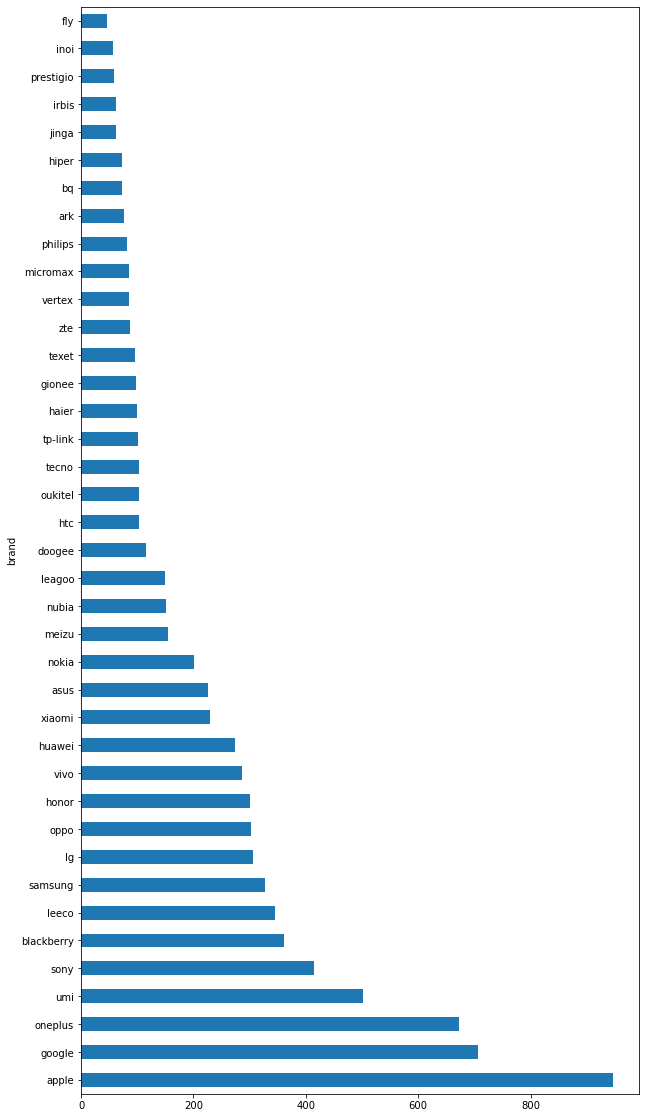

In [152]:
import matplotlib.pyplot as plt
def category_by_brand(n = input()):
    return df[df.category_code == n].groupby('brand').price.mean().sort_values(ascending = False).plot.barh(figsize = (10,20))
    
category_by_brand()

### $3.2$ Find, for each category, the brand with the highest average price. Return all the results in ascending order by price.

Here we simply used the dataset previously generated for exercise $3.0$ and, then, printed it in ascending order.

In [153]:
cb_ag.nlargest(1).sort_values()

category_code  brand     
medicine       gamma           61.750000
stationery     xerox           66.670000
apparel        weekend        472.817407
accessories    weekend        534.668571
country_yard   viking         722.501579
furniture      laufen        1134.115000
construction   kelet         1334.158333
computers      apple         1602.053461
auto           schneider     1807.466875
kids           minimotors    1973.066905
electronics    rado          2248.018889
appliances     climadiff     2524.770000
sport          pinarello     2573.810000
Name: avg_price, dtype: float64

# $RQ4$

### $4.0$ How much does each brand earn per month?

In this case, we have divided the purchase-dataset for the months of October and November. For both months we group the data frame by brand and, then, sum all product's prices for each brand.

In [154]:
#October
purchase_oct = october[october.event_type == 'purchase']
print("OCTOBER")
purchase_oct.groupby('brand').price.sum()

OCTOBER


brand
a-case          5.10
acer        49605.81
acme           56.37
adamex        463.31
adata         197.90
              ...   
yokohama     2374.33
zelmer         31.66
zeppelin      393.83
zeta          635.45
zlatek        102.92
Name: price, Length: 507, dtype: float64

In [155]:
#November
purchase_nov=november[november.event_type == 'purchase']
print("NOVEMBER")
purchase_nov.groupby('brand').price.sum()

NOVEMBER


brand
a-case          5.12
acer        31267.83
acme          209.51
acuvue         24.45
adidas        108.11
              ...   
zeppelin       16.86
zeta         1222.76
zlatek         51.46
zte            77.20
zubr           14.41
Name: price, Length: 531, dtype: float64

### $4.1$ Write a function that given the name of a brand in input returns, for each month, its profit.

For this exercise, we computed the $profit$ as the sum of the prices of all sold products. Our function takes a brand's name and returns the total amount of sales that brand had for October and November.

In [156]:
def brand_sale(n = input()):
    print("October profit: ", purchase_oct[purchase_oct.brand == n].price.sum(), "$")
    print("November profit: ", purchase_nov[purchase_nov.brand == n].price.sum(), "$")
    
brand_sale()

 apple


October profit:  1519044.45 $
November profit:  1393258.4 $


### $4.2$ Is the average price of products of different brands significantly different? 

Here we first group or data frame by $brand$ and $productID$ also aggregating applying the function $mean$ to $price$ field. Then we group the aggregated data frame again by $brand$ in order to obtain all the average prices and, for each brand, we compute the mean. Once obtained the mean price for brand, we pick the minimum and the maximum mean price in order to provide a measure of the range of prices associated to our store. 

In [157]:
avg_brand_price = df.groupby(['brand' ,'product_id']).agg(avg_price = ('price','mean'))
avg_brand_price = avg_brand_price['avg_price'].groupby('brand', group_keys = False)
x = avg_brand_price.mean()
max_dif_min = x.max() - x.min()
print(x)
print("")
print("The difference between the max and the min mean price is equal to ", max_dif_min, "$")

brand
a-case       14.059697
a-derma      17.143333
a-elita       8.490000
a-mega       72.580000
aardwolf     84.430000
               ...    
zotac       346.180000
zte          96.943333
zubr        307.018000
zuru         12.840000
zyxel       138.772381
Name: avg_price, Length: 2684, dtype: float64

The difference between the max and the min mean price is equal to  2572.3900000000003 $


As we can see from the result, the difference between the highest priced brand and the lowest priced one in average is signaficantly high. Therefore, we can deduce that the e-commerce we are analyzing deals with extremely heterogeneous types of products and brands.

### $4.3$ Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next, specifing both the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).

First we computed the total sales of each brand for each month, then we calculates the difference and divided it by total October sales in order to obtain the percentual loss each brand has had between November and October.

In [159]:
purchase_october = october[october.event_type == 'purchase']
purchase_november = november[november.event_type == 'purchase']
loss_percentage = 100 * (purchase_october.groupby('brand').price.sum() - purchase_november.groupby('brand').price.sum()\
)/purchase_october.groupby('brand').price.sum()
print("Below there are the top 3 brands with the highest loss-percentage between October and November 2019")
loss_percentage.sort_values(ascending = False).head(3)

Below there are the top 3 brands with the highest loss-percentage between October and November 2019


brand
zeppelin    95.718965
karya       95.398916
oneplus     93.454693
Name: price, dtype: float64

# $RQ5$

### $5.0$ In what part of the day is your store most visited?

Here we first created the views dataframe which only contains views in order to split data in hourly groups from 0 to 23 and in the final result which is the most busy hour we can see the number of views

In [160]:
views = df[df.event_type == 'view']
views.groupby([views.event_time.dt.hour , views.event_type]).event_type.count().nlargest(1)

event_time  event_type
8           view          147525
Name: event_type, dtype: int64

### $5.1$  Knowing which days of the week or even which hours of the day shoppers are likely to visit your online store and make a purchase may help you improve your strategies. Create a plot  that for each day of the week show the hourly average of visitors your store has.

Here we used the same dataframe views as our dataframe. We splitted our dataframe by days of the week and we counted how many views it has in total, then we obtained the average by dividing the number by 24 (maximum hour for a day). In order to create the plot we turn them into lists to use them in the xlabel indexes so we have a more precise plot to show the actual names of the days of the week.

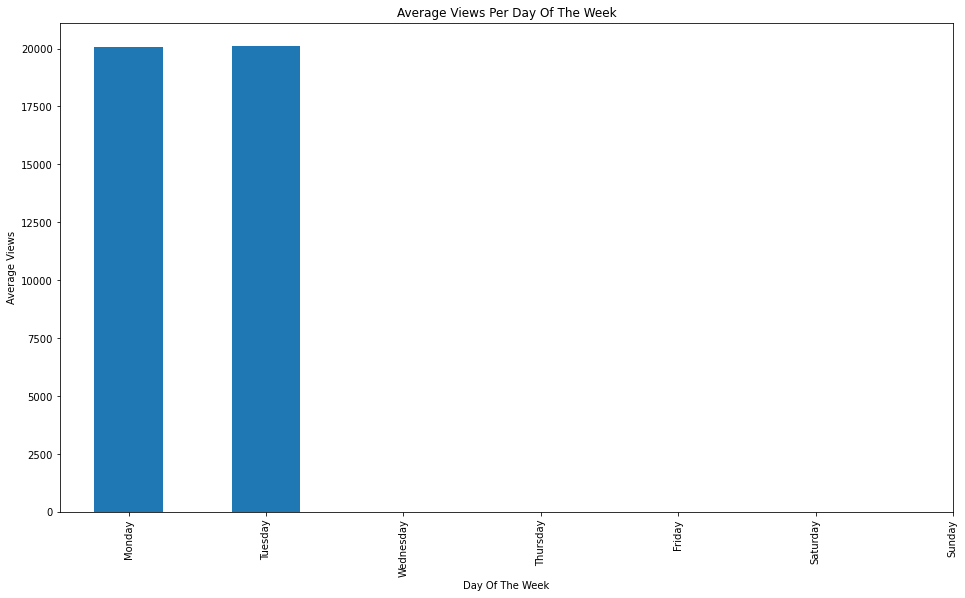

In [161]:
views = df[df.event_type == "view"]
tot_views_daily = views.groupby([views.event_time.dt.dayofweek, views.event_type]).event_type.count()
avg_views_daily = tot_views_daily / 24
day_number = [0,1,2,3,4,5,6]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
plt.figure()
avg_views_daily.plot.bar(figsize = (16,9))
plt.title("Average Views Per Day Of The Week")
plt.xlabel("Day Of The Week")
plt.ylabel("Average Views")
plt.xticks(day_number,days)
plt.show()

# $RQ6$

### $6.0$ The conversion rate of a product is given by the number of times a product has been bought over the number of times it has been visited. What's the conversion rate of your online store? Find the overall conversion rate of your store.

Here, in this exercise, we simply obtain the number of views by using the existing views-dataframe that we have created before and we use a pretty simple code in order to obtain the number of purchases; then we divide purchases by views and we get the store coversion rate.

In [162]:
purchases = df[df.event_type == 'purchase']
store_conv_rate = purchases.event_type.count() / views.event_type.count()
print("The overall conversion rate for our store is equal to: ", store_conv_rate.round(3))

The overall conversion rate for our store is equal to:  0.02


### $6.1$ Plot the number of purchases of each category and show the conversion rate of each category in decreasing order.

Here we produce two plots: 
1) The first one contains the number of purchases for each category, shown in decreasing order.<br>
2) The second one contains the conversion rate for each category, shown in decreasing order.

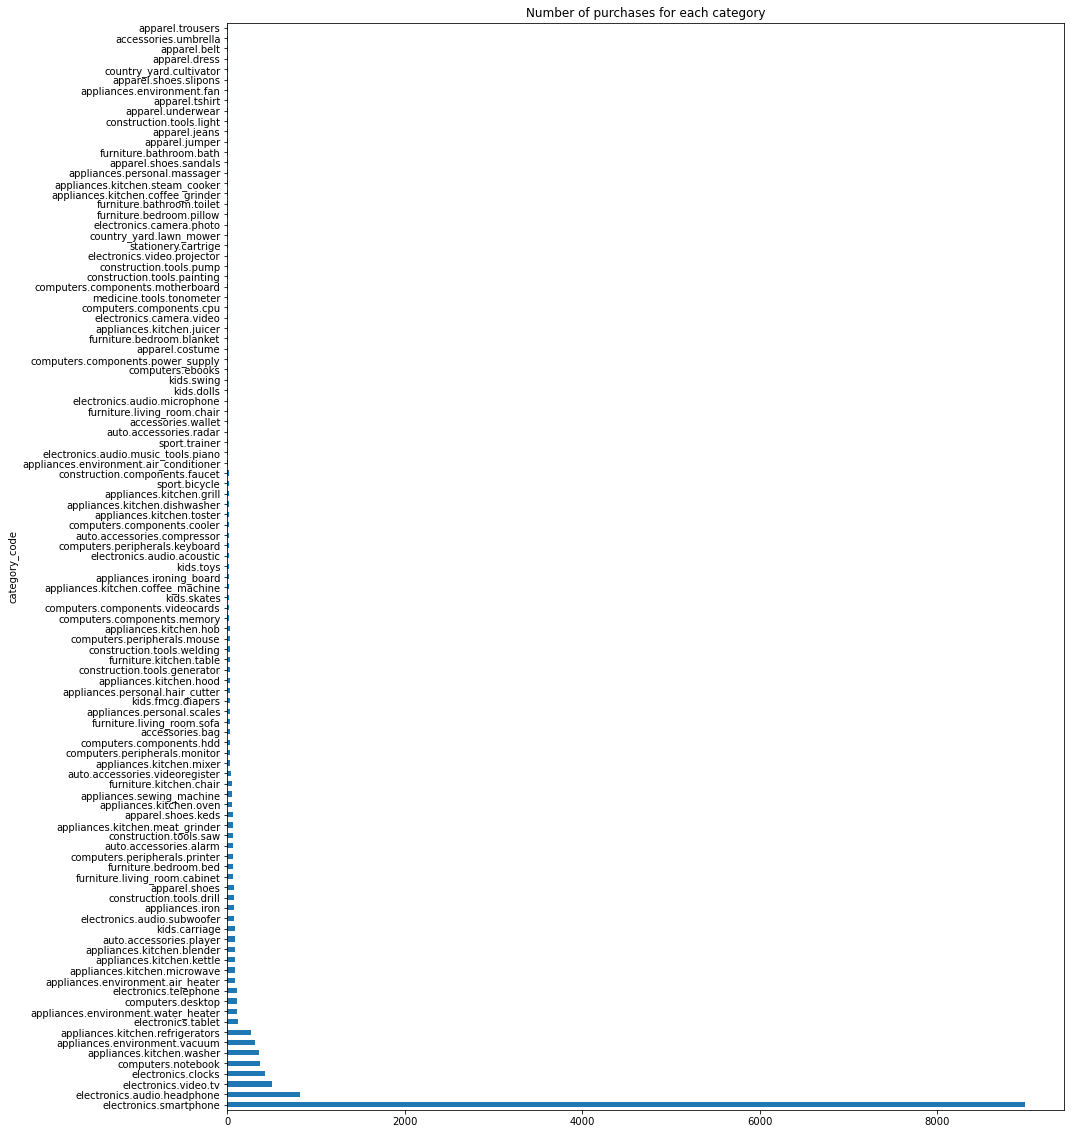

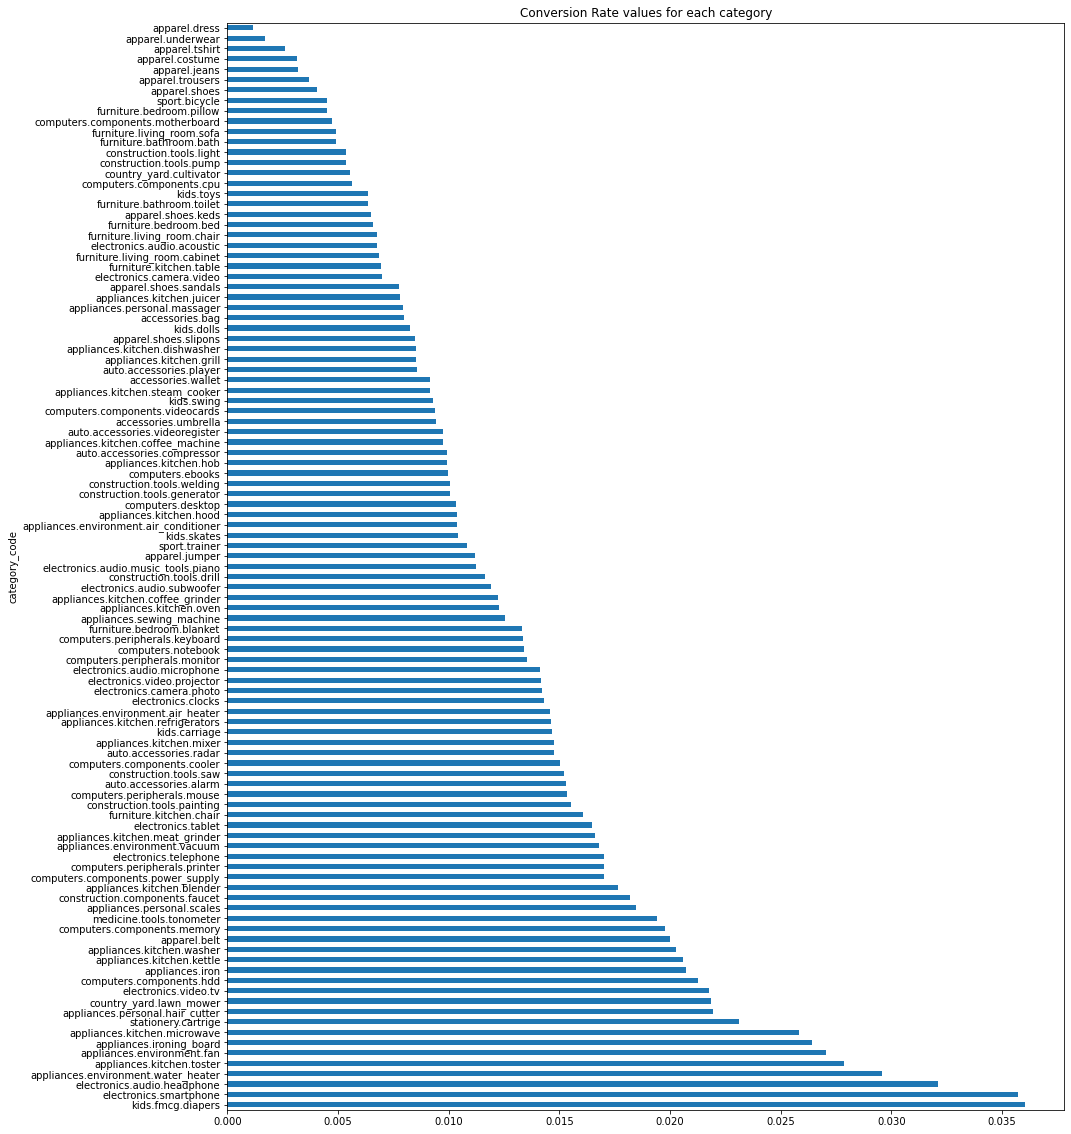

In [164]:
view_cat_not_null = views.groupby('category_code').event_type.count()
purchase_cat_not_null = purchases.groupby('category_code').event_type.count().sort_values(ascending = False)
categories = (purchase_cat_not_null / view_cat_not_null).dropna().sort_values(ascending = False)
plt.figure(figsize = (15,20))
purchase_cat_not_null.plot.barh()
plt.title("Number of purchases for each category")
plt.show()
plt.figure(figsize = (15,20))
categories.plot.barh()
plt.title("Conversion Rate values for each category")
plt.show()

# $RQ7$

### The Pareto principle states that for many outcomes roughly 80% of consequences come from 20% of the causes. Also known as 80/20 rule, in e-commerce simply means that most of your business, around 80%, likely comes from about 20% of your customers. Prove that the pareto principle applies to your store.

Here we just count the number of users who bought at least one product. Finally, we compute the percentage of purchases (compared to the overall profit) coming from the 20% of buyer users.

In [165]:
number_of_buyers = purchases.user_id.nunique()
purchases.groupby('user_id').price.sum().nlargest(int(number_of_buyers / 5)).sum() / purchases.price.sum()

0.633206233041425

As we can see, according with the data contained in our dataset, the percentage obtained is slightly above 60%.
It seems that the Pareto principle cannot be applied to the shop we are analyzing. At least, as far as only the months of October and November 2019 are concerned.